## 1. Import all packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob, time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

## 2. Load images into numpy array

In [2]:
images = glob.glob('training_images/*/*/*')

cars = []
noncars = []
for image in images:
    if 'non' in image:
        noncars.append(image)
    else:
        cars.append(image)

def read_img(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Change this after the testing

cars = np.array(list(map(lambda img_path: read_img(img_path), cars)))
noncars = np.array(list(map(lambda img_path: read_img(img_path), noncars)))

# Shuffling the dataset
cars, noncars = shuffle(cars, noncars)

print(cars.shape)
print(noncars.shape)

(8792, 64, 64, 3)
(8968, 64, 64, 3)


#### Visualise sample image

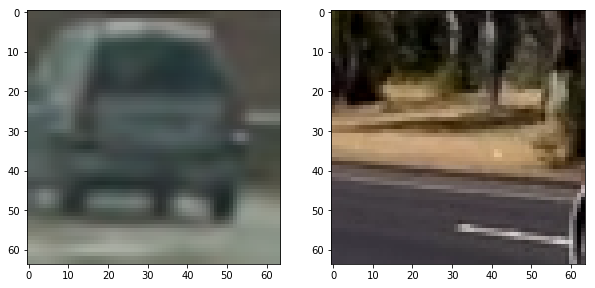

In [3]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(cars[0])
plt.subplot(122)
plt.imshow(noncars[4])

## 3. Feature extraction

In [4]:
def bin_spatial(img, size=(32, 32)):
    """
    Create a feature vector of the image
    """
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Returns the feature vector of color histograms
    """
    c1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
    return hist_features

def extract_hog_features(img, orientations, pixels_per_cell, cells_per_block, visualise=False, feature_vec=True):
    """
    Get feature vector and hog image
    """
    if visualise is True:
        features, hog_image = hog(img, orientations=orientations, 
                                      pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                      cells_per_block=(cells_per_block, cells_per_block), 
                                      transform_sqrt=True, 
                                      visualise=True, feature_vector=feature_vec, block_norm='L1')
        
        return features, hog_image
    else:
        features = hog(img, orientations=orientations, 
                                      pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                      cells_per_block=(cells_per_block, cells_per_block), 
                                      transform_sqrt=True, 
                                      visualise=False, feature_vector=feature_vec, block_norm='L1')
        return features

#### Feature image visualization

/home/mindspace/softwares/miniconda3/envs/ml27-gpu/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


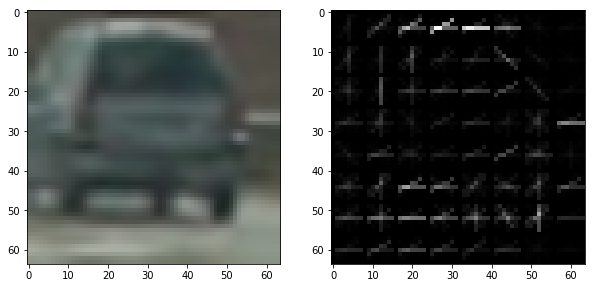

In [5]:
features, hog_image = extract_hog_features(cars[0][:,:,0], 8, 8, 2, visualise=True)

plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(cars[0])
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')

In [6]:
def extract_features(image, color_space='YCrCb', orientation=8, pix_per_cell=8, cell_per_block=2, 
                     size=(16,16), hist_bins = 32, hist_range=(0,256), hog_channel='ALL'):

    """
    Feature extraction pipeline
    """
    global count
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            features = extract_hog_features(feature_image[:,:,channel], 
                                orientation, pix_per_cell, cell_per_block)
            hog_features.append(features)
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = extract_hog_features(feature_image[:,:,hog_channel], 
                                orientation, pix_per_cell, cell_per_block)

    # get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # get color histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))

positive_features = list(map(lambda img: extract_features(img), cars))
negative_features = list(map(lambda img: extract_features(img), noncars))


print('done loading features')

done loading features


## 4. Model fitting

In [7]:
def fit_model(positive_features, negative_features, svc, scalar):
    
    """
    Fit an SVM model
    """
    X = np.vstack((positive_features, negative_features)).astype(np.float64)    
    X_scaler = scalar.fit(X)
    X_scaled = X_scaler.transform(X)

    y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negative_features))))
    
    # test train split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=43)
    
    # Fitting
    t1=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    fittingTime = round(t2 - t1, 2)
    accuracy = round(svc.score(X_test, y_test),4)
    return (svc, X_scaler, fittingTime, accuracy)

In [8]:
svc, scaler, fittingTime, accuracy = fit_model(positive_features, negative_features, 
                                               LinearSVC(), StandardScaler())
print('Fitting time: {} s, Accuracy: {}'.format(fittingTime, accuracy))

Fitting time: 18.16 s, Accuracy: 0.9938


## 5. Visualising HOG

(8792, 64, 64, 3)
(8968, 64, 64, 3)


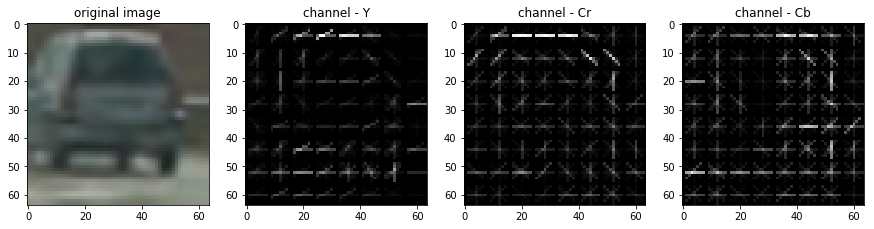

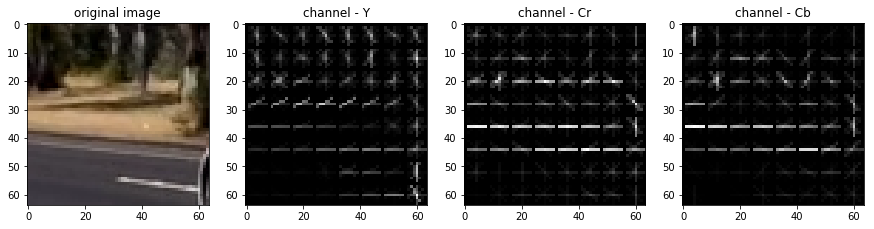

In [9]:
def show_hog_features(img, orientation=8, pix_per_cell=8, cell_per_block=2):
    """
    Calculate HOG on the image `img` and the YCrCb color space and show them on a graph.
    """
    org_img = np.copy(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    _, y = extract_hog_features(img[:,:,0], 
                                    orientation, pix_per_cell, cell_per_block, visualise=True)
    _, Cr = extract_hog_features(img[:,:,1], 
                                    orientation, pix_per_cell, cell_per_block, visualise=True)
    _, Cb = extract_hog_features(img[:,:,2], 
                                    orientation, pix_per_cell, cell_per_block, visualise=True)

    fig, axes = plt.subplots(1,4, figsize=(15,15))
    axes.ravel()
    axes[0].imshow(org_img)
    axes[0].set_title('original image')
    axes[1].imshow(y, cmap='gray')
    axes[1].set_title('channel - Y')
    axes[2].imshow(Cr, cmap='gray')
    axes[2].set_title('channel - Cr')
    axes[3].imshow(Cb, cmap='gray')
    axes[3].set_title('channel - Cb')

show_hog_features(cars[0])
show_hog_features(noncars[4])

print(cars.shape)
print(noncars.shape)

#### Loading test images

In [10]:
test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), glob.glob('./test_images/*.jpg')))

## 6. Sliding window search

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    """draw boxes on an image"""
    img_copy = np.copy(img)

    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], color, thick)
    return img_copy

def get_cells(img, window_size=(64, 64), start=[None, None], stop=[None, None]):
    """
    Returns a list of windows of given size
    """
    if start[0] == None:
        start[0] = 0
    if start[1] == None:
        start[1] = 0
    if stop[0] == None:
        stop[0] = img.shape[1]
    if stop[1] == None:
        stop[1] = img.shape[0]
        
    xspan = stop[0] - start[0]
    yspan = stop[1] - start[1]
    
    xsteps = xspan//window_size[0]
    ysteps = yspan//window_size[1]
    
    print(xsteps)
    print(ysteps)
    
    windows = []
    
    for ny in range(ysteps):
        for nx in range(xsteps):
            start_x = nx*window_size[0] + start[0]
            end_x = start_x + window_size[0]
            
            start_y = ny*window_size[1] + start[1]
            end_y = start_y + window_size[1]
            windows.append(((start_x, start_y), (end_x, end_y)))
            
    return windows

#### Visulizing get_cells function

20
11


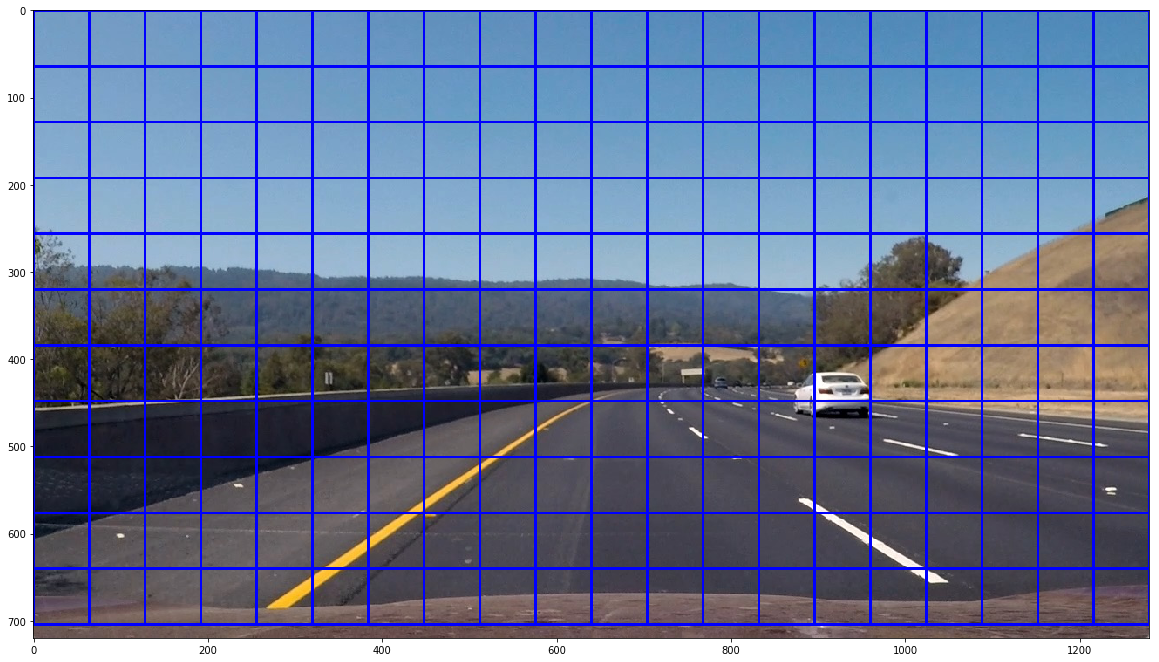

In [12]:
win = get_cells(test_images[0])
im = draw_boxes(test_images[0], win)

plt.figure(figsize=(20,20))
plt.imshow(im)

In [13]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

#### Visualizing slide_window function

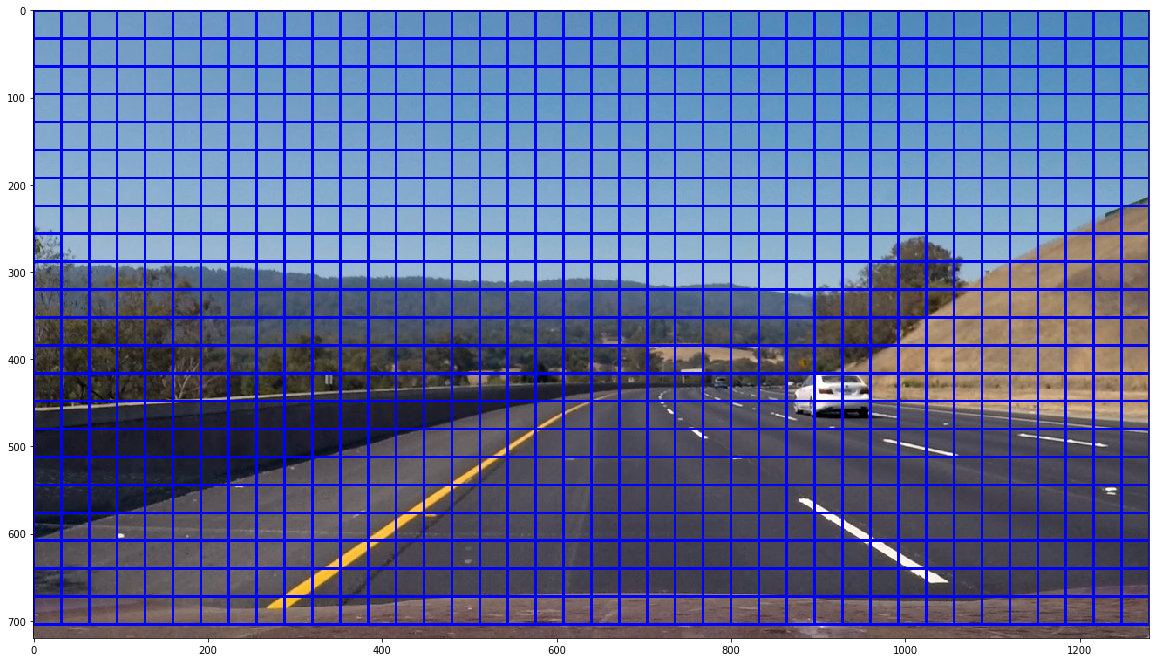

In [14]:
win = slide_window(test_images[0], xy_overlap=(0.5, 0.5))
im = draw_boxes(test_images[0], win, thick=2)

plt.figure(figsize=(20,20))
plt.imshow(im)

In [15]:
def find_car_windows(img, classifier, scaler, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    """
    returns the windows where cars are detected
    """
    car_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = classifier.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

def draw_car_windows(img, windows):
    """
    Draw the windows on the image
    """
    output = np.copy(img)
    return draw_boxes(output, windows)

In [16]:
car_test_images = list(map(lambda img: draw_car_windows(img, find_car_windows(img, svc, scaler)), test_images))

In [17]:
def show_images(images):
    image_count = len(images)

    fig, axes = plt.subplots(image_count, 1, figsize=(20,20))
    axes = np.ravel(axes)
    for i in range(image_count):
        axes[i].imshow(images[i])

#### Drawing identified boxes on the test images

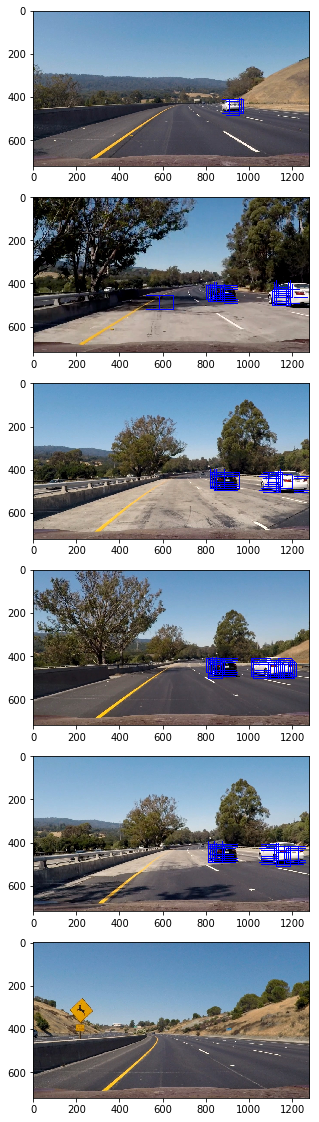

In [18]:
show_images(car_test_images)

In [19]:
def add_heat(heatmap, bbox_list):
    """
    returns a heat map of the bounding boxes
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from scipy.ndimage.measurements import label

def draw_labels_on_cars(img, boxes, threshold = 4):
    """
    Draw boxes on the image applying heatmap and threshold
    """
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap_thresholded = apply_threshold(heatmap, threshold)
    labels = label(heatmap_thresholded)
    
    return draw_labeled_bboxes(np.copy(img), labels)


In [20]:
test_img_labelled = list(map(lambda img: draw_labels_on_cars(img, find_car_windows(img, svc, scaler)), test_images))

#### Drawing again after heatmap implementation

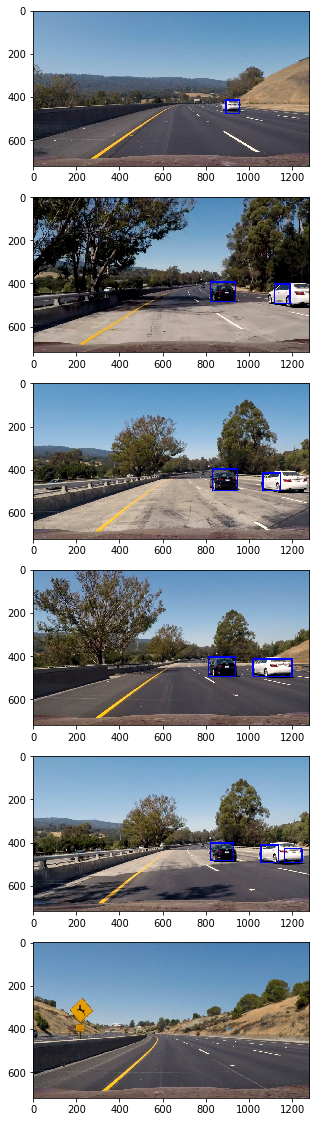

In [21]:
show_images(test_img_labelled)

In [22]:
def find_boxes(img, clf, scaler, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5,
              cspace = 'YCrCb', orient = 8, pix_per_cell = 8, cell_per_block = 2, hog_channel = 'ALL',
               size = (16, 16), hist_bins = 32, hist_range = (0, 256)):
    """
    """
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = extract_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = extract_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = extract_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows


In [23]:
car_boxes = list(map(lambda img: find_boxes(img, svc, scaler), test_images))

car_marked_test_images = list(map(lambda img_box: draw_car_windows(img_box[0], img_box[1]), zip(test_images, car_boxes)))

#### HOG sub-sampling results

6


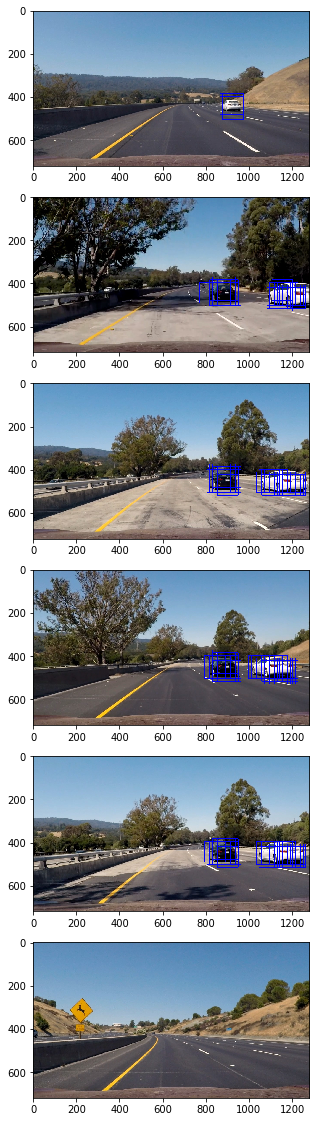

In [24]:
show_images(car_marked_test_images)

#### Hog subsampling along with heatmap and thresholding

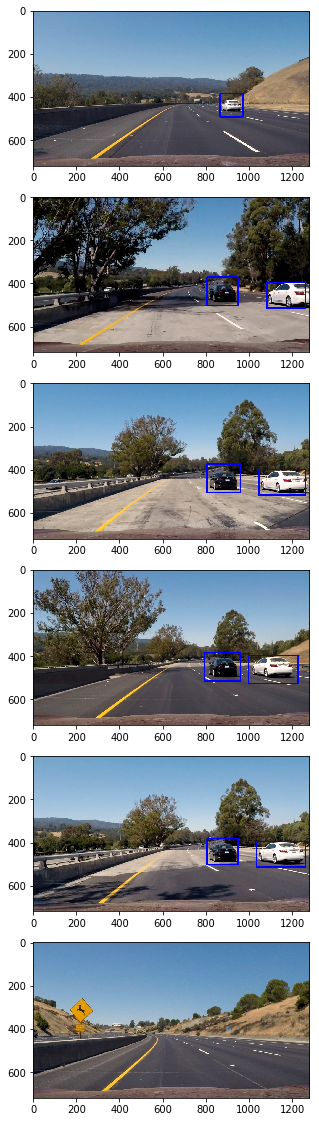

In [25]:
final_test_images = list(map(lambda img_box: draw_labels_on_cars(img_box[0], img_box[1], threshold=1), zip(test_images, fast_boxes)))

show_images(final_test_images)

## 7. Running the pipeline on videos

In [27]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from functools import reduce


history = []

def process_video(input_filename, output_filename, frames_to_remember=3, threshold=1):
    """
    Pipeline function for video processing
    """
    def pipeline(img):
        
        global history
        
        car_boxes = find_boxes(img, svc, scaler)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), car_boxes)
        if len(history) >= frames_to_remember:
            history = history[1:]

        history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    vid = VideoFileClip(input_filename)
    output_video = vid.fl_image(pipeline)
    output_video.write_videofile(output_filename, audio=False)
    
process_video('./lane_detected.mp4', './lane_plus_car_test.mp4', threshold=2)

[MoviePy] >>>> Building video ./lane_plus_car.mp4
[MoviePy] Writing video ./lane_plus_car.mp4


100%|█████████▉| 1260/1261 [56:01<00:02,  2.70s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./lane_plus_car.mp4 

